In [ ]:
!pip install umap-learn

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re

import hdbscan
import sklearn.cluster
import sklearn.manifold
import umap


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

In [3]:
trips = clean_data.load_clean_ridewgps_trips()
trips.head()

,id,departed_at,duration,distance,elevation_gain,description,name,avg_speed,max_speed,moving_time,is_stationary,user_id,update_days,if_updated,elevation_net,photos,big_user,crow_distance,if_weekend,prop_moving
0,23209396,2018-04-30T02:50:43-07:00,0.619444,2.659848,123.437454,,04/30/18,5.002846,7.048852,0.531667,False,50396,0,False,17.273481,False,True,1.116021e-04,False,0.858296
1,54372107,2020-08-15T03:04:55-07:00,0.540556,2.762263,142.176885,,08/15/20,5.171163,5.960829,0.534167,False,50396,0,False,-30.236712,False,True,2.040744e-08,False,0.988181
2,48496079,2020-05-08T12:11:50-07:00,0.535278,2.777424,480.997881,,05/08/20,5.518063,11.760722,0.503333,False,490190,0,False,87.563328,False,True,6.240184e-06,False,0.940322
3,40433541,2019-09-23T11:49:34-07:00,0.580000,2.779512,57.147474,,09/23/19,5.192650,5.432662,0.535278,False,268854,0,False,15.291757,False,True,8.141466e-10,False,0.922893
4,47936294,2020-04-28T15:55:10-07:00,1.990278,2.795935,299.426029,,04/28/20,5.470311,7.853530,0.511111,False,490190,0,False,-7.594531,False,True,4.518103e-09,False,0.256804


In [100]:
# useful_cols = ['duration', 'distance', 'elevation_gain', 'avg_speed',
#               'max_speed', 'if_updated', 'photos', 'big_user',
#               'crow_distance', 'if_weekend', 'prop_moving']

trips['avg_slope'] = trips['elevation_gain'] / trips['distance'] / 52.8
useful_cols = ['distance', 'avg_slope', 'avg_speed', 'prop_moving']
rides_use = trips[useful_cols].copy()
CAP_SLOPE = 10
rides_use['avg_slope'] = rides_use['avg_slope'].apply(lambda x: CAP_SLOPE if CAP_SLOPE < x else x)# cap at 12%
for col in rides_use.columns:
    if rides_use[col].dtype in ['float64']:
        rides_use[col] = rides_use[col] / rides_use[col].max()
rides_use['avg_slope'] *= 2        

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.axes()
sns.boxplot(x='labels', y='avg_slope', data=df[df.labels >= 0])

(array([7.5930e+03, 1.1886e+04, 1.0930e+03, 2.0200e+02, 9.4000e+01,
        3.1000e+01, 1.8000e+01, 7.0000e+00, 1.0000e+00, 4.9000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

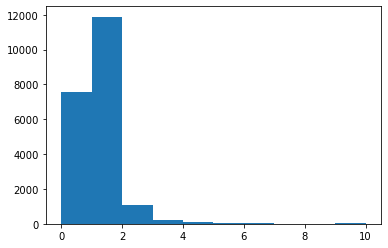

In [71]:
plt.hist(rides_use.avg_slope)

<AxesSubplot:xlabel='labels', ylabel='duration'>

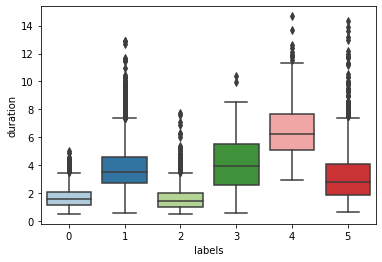

In [116]:

sns.boxplot(data=df, x='labels', y='duration', palette=colours)
# plt.ylim([0, 15])

<AxesSubplot:xlabel='duration', ylabel='Count'>

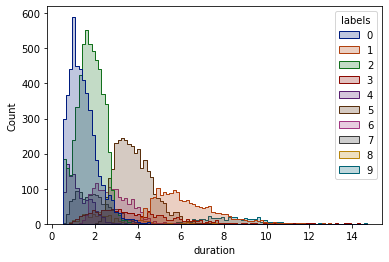

In [47]:
sns.histplot(data=df, x='duration', hue='labels', element='step', palette='dark')#, palette=colours)

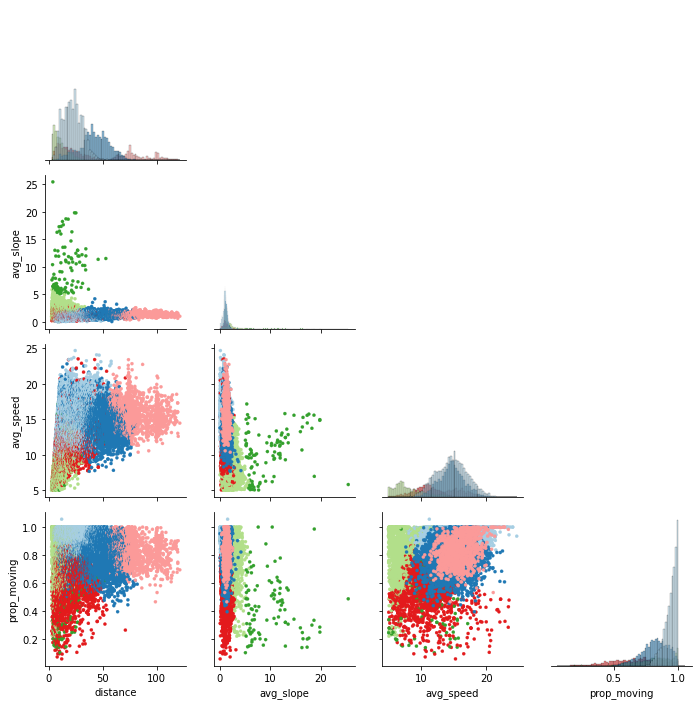

In [108]:
colours = sns.color_palette('Paired', df.labels.nunique() - min(df.labels))
g = sns.PairGrid(df, hue='labels', palette=colours, corner=True)
g.map_offdiag(sns.scatterplot, edgecolor=None, s=10)
g.map_diag(sns.histplot)

In [115]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=100,
#                             min_samples=1,
#                            cluster_selection_epsilon=0.)
clusterer = sklearn.cluster.AgglomerativeClustering(n_clusters=6)
clusterer.fit(rides_use)
print(len(set(clusterer.labels_)))
df = trips.copy()
df['labels'] = clusterer.labels_
print(df[df['labels'] >= 0].shape)
if df.labels.nunique() < 20:
    print(df.labels.value_counts())

6
(20974, 22)
0    9088
1    5790
2    2351
5    2236
4    1413
3      96
Name: labels, dtype: int64


In [ ]:
mapped_clusters = sklearn.manifold.TSNE(n_components=2, metric='cosine', init='pca').fit_transform(rides_use)
x = mapped_clusters[:, 0]
y = mapped_clusters[:, 1]

In [122]:
clusterer.affinity

'euclidean'

In [121]:
df_save = df[['id', 'labels']]
df_save.to_csv('data/processed/ridewgps_labelled.csv', index=False)

In [6]:
reducer = umap.UMAP().fit_transform(rides_use)
xu = reducer[:, 0]
yu = reducer[:, 1]

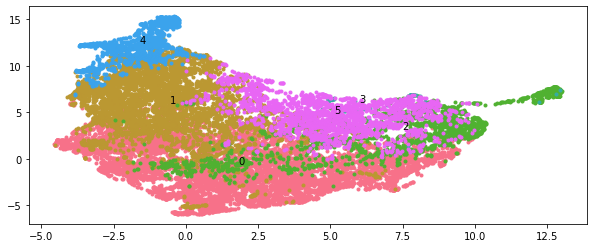

In [102]:
plot_clusters.plot_cluster_2d(rides_use, clusterer.labels_, xu, yu)

In [ ]:
for lab in sorted(df['labels'].unique())[::-1]:
    dfslice = df[df['labels'] == lab]
    print('{:2.0f}: {:5.0f} values'.format(lab, dfslice.shape[0]))
#     for col in dfslice.columns:
#         if col == 'labels': continue
#         print('\t{:15s}: {:.2f} +- {:.2f}'.format(
#             col, dfslice[col].mean() * trips[col].mean(),
#             dfslice[col].std() * trips[col].mean(),
#         ))

In [52]:

for col in df.columns:

    for lab in sorted(df['labels'].unique()):
        dfslice = df[df['labels'] == lab]
#         if dfslice.shape[0] < 400: continue
        print('{:15s} ({:2.0f}): {:.2f} +- {:.2f}'.format(
            col, lab, dfslice[col].mean(), dfslice[col].std(),
        ))
    print('\n')

distance        ( 0): 17.65 +- 7.07
distance        ( 1): 66.10 +- 11.38
distance        ( 2): 24.92 +- 7.73
distance        ( 3): 21.28 +- 10.92
distance        ( 4): 7.15 +- 3.24
distance        ( 5): 42.03 +- 9.40
distance        ( 6): 45.09 +- 12.30
distance        ( 7): 13.73 +- 6.03
distance        ( 8): 8.36 +- 4.06
distance        ( 9): 101.95 +- 7.36


avg_slope       ( 0): 1.00 +- 0.55
avg_slope       ( 1): 1.30 +- 0.34
avg_slope       ( 2): 1.20 +- 0.42
avg_slope       ( 3): 1.78 +- 2.76
avg_slope       ( 4): 1.81 +- 1.24
avg_slope       ( 5): 1.17 +- 0.36
avg_slope       ( 6): 1.22 +- 0.31
avg_slope       ( 7): 1.39 +- 0.84
avg_slope       ( 8): 2.11 +- 1.35
avg_slope       ( 9): 1.29 +- 0.28


avg_speed       ( 0): 13.43 +- 2.45
avg_speed       ( 1): 14.26 +- 1.98
avg_speed       ( 2): 15.51 +- 1.90
avg_speed       ( 3): 11.84 +- 3.01
avg_speed       ( 4): 6.82 +- 1.18
avg_speed       ( 5): 13.62 +- 1.92
avg_speed       ( 6): 17.49 +- 1.60
avg_speed       ( 7): 9.77 +- 1.8

In [ ]:
lab = 1
plt.hist(trips[df['labels'] == lab]['distance'])